<a href="https://colab.research.google.com/github/ananassta/recommendation_system/blob/main/Recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Подключение всего необходимого**

In [1]:
!pip3 install pyspark

In [2]:
!pip install lightfm

In [3]:
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-04-03 13:20:01--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  73.4MB/s    in 2.6s    

2022-04-03 13:20:04 (73.4 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
import os
import zipfile

from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()

sc = spark.sparkContext

In [7]:
local_zip = './ml-20m.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

# **Подготовка данных для ALS**

In [8]:
movie_rating = sc.textFile('/ml-20m/ratings.csv')

header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: (line!=header)) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

rating_data.take(3)

[(1, 2, 3.5), (1, 29, 3.5), (1, 32, 3.5)]

In [ ]:
trainRDD, validationRDD, testRDD = rating_data.randomSplit([.6, .2, .2], seed=1)
trainRDD = trainRDD.cache()
validationRDD.cache()
testRDD.cache()

Соотношение для разделения выборки более точно будет подобрано в дальнейшем.

Здесь мы просто знакомимся с необходимым форматом входных данных. 

# **Подготовка данных для LightFM**

In [7]:
df_ratings = pd.read_csv('/ml-20m/ratings.csv')
del df_ratings['timestamp']

df_titles = pd.read_csv('/ml-20m/movies.csv')

In [10]:
def drop_nan_column(df):
  if (np.nan in df.columns):
    df.drop(columns=[np.nan], inplace=True)
  return df

In [11]:
def df_merge(df1, df2):
  df1 = drop_nan_column(df1)
  df2 = drop_nan_column(df2)

  df_12 = pd.merge(df1, df2, 'outer', on=['movieId'])

  if ('Romance_x' in df_12.columns):
    df_12['Romance'] = df_12['Romance_x'].fillna(df_12['Romance_y'])
    df_12.drop(columns=['Romance_x', 'Romance_y'], inplace=True)

  if ('Adventure_x' in df_12.columns):
    df_12['Adventure'] = df_12['Adventure_x'].fillna(df_12['Adventure_y'])
    df_12.drop(columns=['Adventure_x', 'Adventure_y'], inplace=True)

  if ('Animation_x' in df_12.columns):
    df_12['Animation'] = df_12['Animation_x'].fillna(df_12['Animation_y'])
    df_12.drop(columns=['Animation_x', 'Animation_y'], inplace=True)

  if ('Children_x' in df_12.columns):
    df_12['Children'] = df_12['Children_x'].fillna(df_12['Children_y'])
    df_12.drop(columns=['Children_x', 'Children_y'], inplace=True)

  if ('Comedy_x' in df_12.columns):
    df_12['Comedy'] = df_12['Comedy_x'].fillna(df_12['Comedy_y'])
    df_12.drop(columns=['Comedy_x', 'Comedy_y'], inplace=True)  
  
  if ('Crime_x' in df_12.columns):
    df_12['Crime'] = df_12['Crime_x'].fillna(df_12['Crime_y'])
    df_12.drop(columns=['Crime_x', 'Crime_y'], inplace=True)
    
  if ('Documentary_x' in df_12.columns):
    df_12['Documentary'] = df_12['Documentary_x'].fillna(df_12['Documentary_y'])
    df_12.drop(columns=['Documentary_x', 'Documentary_y'], inplace=True)
 
  if ('Drama_x' in df_12.columns):
    df_12['Drama'] = df_12['Drama_x'].fillna(df_12['Drama_y'])
    df_12.drop(columns=['Drama_x', 'Drama_y'], inplace=True)
  
  if ('Fantasy_x' in df_12.columns):
    df_12['Fantasy'] = df_12['Fantasy_x'].fillna(df_12['Fantasy_y'])
    df_12.drop(columns=['Fantasy_x', 'Fantasy_y'], inplace=True)

  if ('Horror_x' in df_12.columns):
    df_12['Horror'] = df_12['Horror_x'].fillna(df_12['Horror_y'])
    df_12.drop(columns=['Horror_x', 'Horror_y'], inplace=True)

  if ('IMAX_x' in df_12.columns):
    df_12['IMAX'] = df_12['IMAX_x'].fillna(df_12['IMAX_y'])
    df_12.drop(columns=['IMAX_x', 'IMAX_y'], inplace=True)

  if ('Musical_x' in df_12.columns):
    df_12['Musical'] = df_12['Musical_x'].fillna(df_12['Musical_y'])
    df_12.drop(columns=['Musical_x', 'Musical_y'], inplace=True)

  if ('Mystery_x' in df_12.columns):
    df_12['Mystery'] = df_12['Mystery_x'].fillna(df_12['Mystery_y'])
    df_12.drop(columns=['Mystery_x', 'Mystery_y'], inplace=True)

  if ('Sci-Fi_x' in df_12.columns):
    df_12['Sci-Fi'] = df_12['Sci-Fi_x'].fillna(df_12['Sci-Fi_y'])
    df_12.drop(columns=['Sci-Fi_x', 'Sci-Fi_y'], inplace=True)

  if ('Thriller_x' in df_12.columns):
    df_12['Thriller'] = df_12['Thriller_x'].fillna(df_12['Thriller_y'])
    df_12.drop(columns=['Thriller_x', 'Thriller_y'], inplace=True)

  if ('War_x' in df_12.columns):
    df_12['War'] = df_12['War_x'].fillna(df_12['War_y'])
    df_12.drop(columns=['War_x', 'War_y'], inplace=True)

  if ('Western_x' in df_12.columns):
    df_12['Western'] = df_12['Western_x'].fillna(df_12['Western_y'])
    df_12.drop(columns=['Western_x', 'Western_y'], inplace=True)

  if ('Film-Noir_x' in df_12.columns):
    df_12['Film-Noir'] = df_12['Film-Noir_x'].fillna(df_12['Film-Noir_y'])
    df_12.drop(columns=['Film-Noir_x', 'Film-Noir_y'], inplace=True)

  return df_12

In [ ]:
sss = df_titles['genres'].str.split(pat='|', expand=True)
# было выявлено, что максимальное число жанров, относящихся к одному фильму - 10
sss.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
sss['movieId'] = df_titles['movieId']

df_movie_features_1 = pd.DataFrame(sss.pivot(index='movieId', columns='genre1', values='genre1'))
df_movie_features_2 = pd.DataFrame(sss.pivot(index='movieId', columns='genre2', values='genre2'))
df_movie_features_3 = pd.DataFrame(sss.pivot(index='movieId', columns='genre3', values='genre3'))
df_movie_features_4 = pd.DataFrame(sss.pivot(index='movieId', columns='genre4', values='genre4'))
df_movie_features_5 = pd.DataFrame(sss.pivot(index='movieId', columns='genre5', values='genre5'))
df_movie_features_6 = pd.DataFrame(sss.pivot(index='movieId', columns='genre6', values='genre6'))
df_movie_features_7 = pd.DataFrame(sss.pivot(index='movieId', columns='genre7', values='genre7'))
df_movie_features_8 = pd.DataFrame(sss.pivot(index='movieId', columns='genre8', values='genre8'))
df_movie_features_9 = pd.DataFrame(sss.pivot(index='movieId', columns='genre9', values='genre9'))
df_movie_features_10 = pd.DataFrame(sss.pivot(index='movieId', columns='genre10', values='genre10'))

df_movie_features_1.reset_index(inplace=True)
df_movie_features_2.reset_index(inplace=True)
df_movie_features_3.reset_index(inplace=True)
df_movie_features_4.reset_index(inplace=True)
df_movie_features_5.reset_index(inplace=True)
df_movie_features_6.reset_index(inplace=True)
df_movie_features_7.reset_index(inplace=True)
df_movie_features_8.reset_index(inplace=True)
df_movie_features_9.reset_index(inplace=True)
df_movie_features_10.reset_index(inplace=True)

df_movie_features_12 = df_merge(df_movie_features_1, df_movie_features_2)
df_movie_features_34 = df_merge(df_movie_features_3, df_movie_features_4)
df_movie_features_56 = df_merge(df_movie_features_5, df_movie_features_6)
df_movie_features_78 = df_merge(df_movie_features_7, df_movie_features_8)
df_movie_features_910 = df_merge(df_movie_features_9, df_movie_features_10)

df_movie_features_14 = df_merge(df_movie_features_12, df_movie_features_34)
df_movie_features_58 = df_merge(df_movie_features_56, df_movie_features_78)

df_movie_features_18 = df_merge(df_movie_features_14, df_movie_features_58)

df_movie_features = df_merge(df_movie_features_18, df_movie_features_910).fillna(0)

df_movie_features.rename(columns={'(no genres listed)': 'No_genres_listed'}, inplace=True)

for i in df_movie_features.columns:
  if (i!='movieId'):
    df_movie_features.loc[(df_movie_features[i] != 0), i] = 1

print(df_movie_features)

In [ ]:
mf=[]
for i in df_movie_features.columns:
  if (i!='movieId'):
    mf.append(i)
print(mf)

In [ ]:
def feature_colon_value(my_list):
    result = {}
    ll = ['Action', 'No_genres_listed', 'Adventure', 'Animation',
       'Children', 'Documentary', 'Romance', 'Comedy', 'Crime', 'Drama',
       'Fantasy', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Sci-Fi', 'War',
       'Film-Noir', 'Thriller', 'Western']
    aa = my_list
    for x,y in zip(ll,aa):
          result[x] = y
    return result

ad_subset = df_movie_features[['Action', 'No_genres_listed', 'Adventure', 'Animation',
       'Children', 'Documentary', 'Romance', 'Comedy', 'Crime', 'Drama',
       'Fantasy', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Sci-Fi', 'War',
       'Film-Noir', 'Thriller', 'Western']] 
ad_list = [list(x) for x in ad_subset.values]
feature_list = []
for item in ad_list:
    feature_list.append(feature_colon_value(item))
print(f'Final output: {feature_list[0]}')

In [ ]:
movie_tuple = list(zip(df_movie_features.movieId, feature_list))
print(movie_tuple[0])

In [ ]:
deptColumns = ["userId","movieId","rating"]
dfTrain = trainRDD.toDF(deptColumns)
dfTrain = dfTrain.toPandas()

dfValid = validationRDD.toDF(deptColumns)
dfValid = dfValid.toPandas()

dfTest = testRDD.toDF(deptColumns)
dfTest = dfTest.toPandas()

In [ ]:
datasetTrain = Dataset()
datasetValid = Dataset()
datasetTest = Dataset()

datasetTrain.fit(
        df_ratings.userId.unique(),
        df_movie_features.movieId.unique(),
        item_features = mf 
)

datasetValid.fit(
        df_ratings.userId.unique(),
        df_movie_features.movieId.unique(),
        item_features = mf 
)

datasetTest.fit(
        df_ratings.userId.unique(),
        df_movie_features.movieId.unique(),
        item_features = mf 
)

In [ ]:
(interactionsTrain, weightsTrain) = datasetTrain.build_interactions([(x[0], x[1], x[2]) for x in dfTrain.values])
(interactionsValid, weightsValid) = datasetValid.build_interactions([(x[0], x[1], x[2]) for x in dfValid.values])
(interactionsTest, weightsTest) = datasetTest.build_interactions([(x[0], x[1], x[2]) for x in dfTest.values])

In [ ]:
#one for all
item_features = datasetTrain.build_item_features(movie_tuple, normalize= False)

Таким образом мы подготовили все, что необходимо для обучения на LightFM.

# **Метрики**

В данном коде будут рассматриваться две метрики: RMSE и ROC-AUC.

Поскольку для оценки качества работы рекомендательной системы используются, безусловно, бизнес-метрики, но в явном виде их оптимизировать довольно трудно, при обучении моделей также используются различные ML-метрики: RMSE, ROC-AUC, Recall@n, Precision@n, MAP и другие.

В нашем случае алгоритм матричной факторизации, основанный на решении проблемы рекомендательной системы, пытается предсказать рейтинг в тестовом наборе, минимизируя некоторую совокупность различий между его прогнозом и фактическим рейтингом. Поэтому достаточно логично использовать тут такую метрику, как RMSE.

Также стоит задача создать вывод из рекомендаций top-N элементов для пользователя, поэтому можно рассмотреть метрику ROC-AUC, т.е. вероятность того, что рекомендатель поставит случайный "релевантный" элемент выше случайного "не релевантного" элемента.

In [16]:
# для ROC-AUC будем использовать встроенную метрику
# функция для RMSE представлена ниже

def RMSE(trueRDD, predictRDD):
    trueFormattedRDD = trueRDD.map(lambda x: ((x[0], x[1]), x[2]))
    predictFormattedRDD = predictRDD.map(lambda x: ((x[0], x[1]), x[2]))
    count = predictFormattedRDD.count()
    error = (trueFormattedRDD
             .join(predictFormattedRDD)
             .map(lambda x: (x[1][0]-x[1][1])**2)
             .reduce(lambda a,b: a+b))
    return np.sqrt(error/count)

# **ALS**

Для начала будет произведен поиск оптимального объема обучающей выборки на некоторых начальных параметрах с помощью Learning Curves.

Затем получив необходимые наборы данных будет произведен поиск оптимальных параметров модели ALS с помощью валидации:
*   количество итераций (соответствует максимальному количеству итераций во время выполнения),
*   ранг (соответствует количеству факторов в модели ALS, то есть количеству новых строк/столбцов двух матриц, разложенных матрицей),
*   параметр регуляризации (контролирует процесс регуляризации модели, тем самым контролируя переоснащение модели).

После чего мы получим финальную модель, посмотрим на ее точность на тестовой выборке и сделаем top-10 предсказаний для пользователя.

In [ ]:
iter = 5
rank = 8
reg = 0.05
# tests = [[.33,.33],[.6,.2],[.8,.1]]
tests = [[.33,.33],[.4,.3],[.5,.25],[.6,.2],[.7,.15],[.8,.1]]
errorsTrain = []
errorsValid = []
# l = [3,6,8]
l = [3,4,5,6,7,8]

for i,j in tests:
  trainRDD, validationRDD, testRDD = rating_data.randomSplit([i, j, j], seed=1)
  model = ALS.train(
                  ratings=trainRDD,    
                  iterations=iter,
                  rank=rank,
                  lambda_=reg,           
                  seed=1)
  valid_data = validationRDD.map(lambda p: (p[0], p[1]))
  predictions = model.predictAll(valid_data)
  error = RMSE(validationRDD, predictions)
  errorsValid.append(error)

  tr_data = trainRDD.map(lambda p: (p[0], p[1]))
  predictions = model.predictAll(tr_data)
  error = RMSE(trainRDD, predictions)
  errorsTrain.append(error)

plt.plot(l, errorsValid, label='Valid')
plt.plot(l, errorsTrain, label='Train')
plt.legend()
plt.plot()

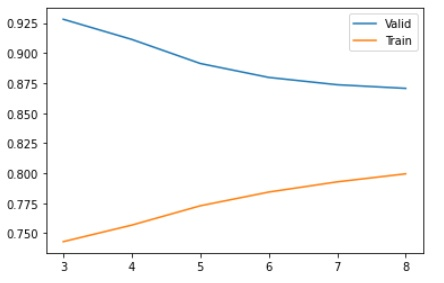

По графику можно заметить, что после 6-ти долей ошибки не очень сильно меняются, т.е. можно сказать, что график практически вышел на плато, поэтому можно было бы выбрать и 7 долей для обучающей выборки, но дальнейшее исследование уже для LightFM, покажет нам, что оптимальное число все-таки 8, поэтому далее будем использовать 8 долей для обучающей выборки.

In [ ]:
trainRDD, validationRDD, testRDD = rating_data.randomSplit([.8, .1, .1], seed=1)

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_iter = -1
    best_rank = -1
    best_regularization = 0
    best_model = None
    arrError = []
    arrIter = []
    arrRank = []
    k = 0
    for iter in num_iters:
      for rank in ranks:
          for reg in reg_param:
              model = ALS.train(
                  ratings=train_data,    
                  iterations=iter,
                  rank=rank,
                  lambda_=reg,           
                  seed=1)
              valid_data = validation_data.map(lambda p: (p[0], p[1]))
              predictions = model.predictAll(valid_data)
              error = RMSE(validation_data, predictions)
              arrError.append(error)
              print('iterations: {} | rank: {} | regularisation parameter: {} | RMSE: {}'.format(iter, rank, reg, error))
              if error < min_error:
                  min_error = error
                  best_iter = iter
                  best_rank = rank
                  best_regularization = reg
                  best_model = model
          plt.plot(reg_param, arrError[k:(k+len(reg_param))])
          k = k + len(reg_param)
          # plt.title('Reg/Error with rank: {}, iter: {}'.format(rank,iter))
          # plt.show()
    plt.title('Reg/Error')
    plt.show()
    print('\nThe best model has {} latent factors, {} iterations and regularization = {}'.format(best_rank, best_iter, best_regularization))
    for m in range(0, len(num_iters)):
      for j in range(0, len(reg_param)):
        l = []
        for i in range(j + m*len(reg_param),len(arrError), len(reg_param)):
          l.append(arrError[i])
        arrRank.append(l)
        plt.plot(ranks, arrRank[j][0:len(ranks)])
        # plt.title('Rank/Error with reg: {}, iter: {}'.format(reg_param[j],num_iters[m]))
        # plt.show()
    plt.title('Rank/Error')
    plt.show()
    for j in range(0, len(reg_param)*len(ranks)):
      l = []
      for i in range(j,len(arrError), len(reg_param)*len(ranks)):
        l.append(arrError[i])
      arrIter.append(l)
      plt.plot(num_iters, arrIter[j][0:len(num_iters)])
      # plt.title('Iter/Error with rank: {}, reg: {}'.format(ranks[int(j/len(reg_params))],reg_param[int(j % len(reg_params))]))
      # plt.show()
    plt.title('Iter/Error')
    plt.show()
    return best_model, best_rank, best_iter, best_regularization

In [ ]:
num_iterations = [2, 5, 10, 12]
ranks = [2, 4, 8, 10]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

final_model, final_rank, final_iter, final_reg = train_ALS(trainRDD, validationRDD, num_iterations, reg_params, ranks)

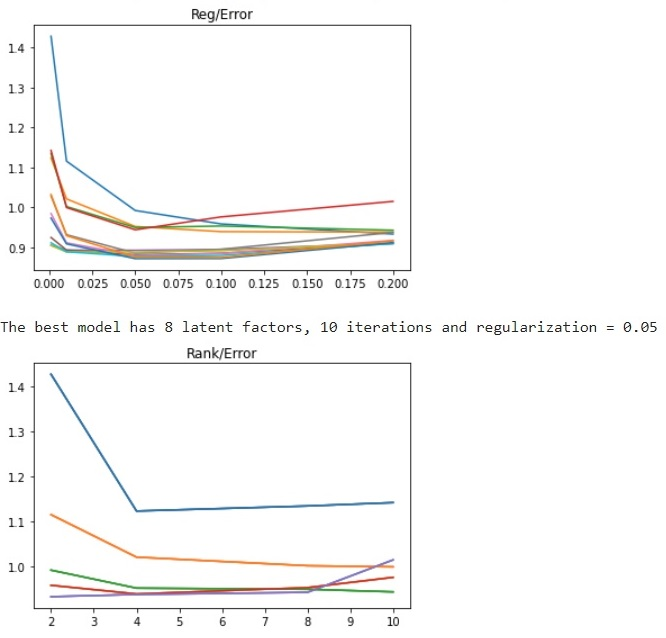

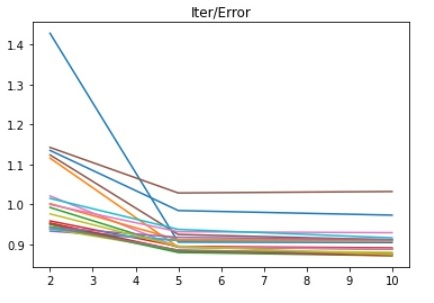

Исходя из полученных граффиков и подсчетов получаем оптимальные параметры:

*   Количество итераций - 5
*   Ранг - 8
*   Параметр регуляризации - 0.05





In [ ]:
mod = ALS.train(trainRDD, final_rank, iterations = final_iter,
                lambda_= final_reg, seed=1)

In [ ]:
testPruneRDD = testRDD.map(lambda x: (x[0],x[1])).cache() 
predictionsRDD = mod.predictAll(testPruneRDD)

rmse = RMSE(testRDD, predictionsRDD)
print(rmse)

0.8687953836258051

In [ ]:
top10 = mod.recommendProducts(5431,10)
top10 = {k:v for (_,k,v) in top10}

for i in top10:
  print('Фильм: ', df_titles[df_titles['movieId']==i].iloc[0]['title'], ' || ID: ', i,' || Рекомендация: ', top10[i])

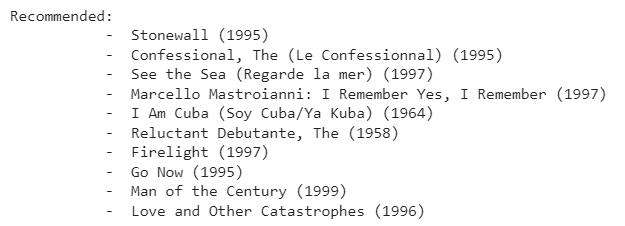

# **LightFM**

Сначала окончательно определимся с долей обучающей выборки, а затем найдем оптимальные параметры модели:
*   количество эпох,
*   число компонент (размерность скрытых вложений функции).

А далее, также как и для ALS, найдем значение метрики на тестовой выборке и сделаем top-10 рекомендаций для пользователя.



In [ ]:
no_comp = 10
epoch = 10
aucValid = []
aucTrain = []
# tests = [[.33,.33],[.6,.2],[.8,.1]]
# l = [3,6,8]
tests = [[.33,.33],[.4,.3],[.5,.25],[.6,.2],[.7,.15],[.8,.1]]
l = [3,4,5,6,7,8]

for i,j in tests:
  print(i)
  trainRDD, validationRDD, testRDD = rating_data.randomSplit([i, j, j], seed=1)
  deptColumns = ["userId","movieId","rating"]
  dfTrain = trainRDD.toDF(deptColumns)
  dfTrain = dfTrain.toPandas()

  dfValid = validationRDD.toDF(deptColumns)
  dfValid = dfValid.toPandas()

  (interactionsTrain, weightsTrain) = datasetTrain.build_interactions([(x[0], x[1], x[2]) for x in dfTrain.values])
  (interactionsValid, weightsValid) = datasetValid.build_interactions([(x[0], x[1], x[2]) for x in dfValid.values])

  model = LightFM(loss='warp', no_components = no_comp)
  model.fit(interactionsTrain,
                  item_features= item_features,
                  sample_weight= weightsTrain,
                  epochs=epoch,
                  num_threads= 4)
  aucV = auc_score(model, train_interactions= interactionsTrain, 
                    test_interactions= interactionsValid, 
                    item_features= item_features, 
                    num_threads= 4).mean()
  aucT = auc_score(model,test_interactions= interactionsTrain, 
                    item_features= item_features, 
                    num_threads= 4).mean()
  aucValid.append(aucV)
  aucTrain.append(aucT)

plt.plot(l, aucValid, label='aucValid')
plt.plot(l, aucTrain, label='aucTrain')
plt.legend()
plt.show()

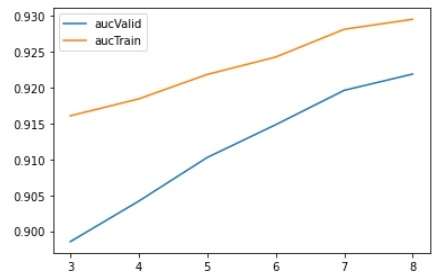


Как уже было сказано выше, мы можем наблюдать, что оптимальное количество долей для обучающей выборки - 8.

In [ ]:
def train_LFM(epochs, no_components, interactionsTrain, interactionsValid, item_features, weightsTrain):
  max_auc = 0
  best_epoch_auc = -1
  best_no_comp_auc = -1
  arrEpochAUCTrTs = []
  arrNoCompAUCTrainTest = []
  for epoch in epochs:
    for no_comp in no_components:
            model = LightFM(loss='warp', no_components = no_comp)
            model.fit(interactionsTrain,
                  item_features= item_features,
                  sample_weight= weightsTrain,
                  epochs=epoch,
                  num_threads= 4)
            
            aucTrTs = auc_score( 
                    model, train_interactions= interactionsTrain, 
                    test_interactions= interactionsValid, 
                    item_features= item_features, 
                    num_threads= 4).mean()
            arrNoCompAUCTrainTest.append(aucTrTs)

            print('epochs: {} | no_components: {} | AUC: {}'.format(epoch, no_comp, aucTrTs))
            if max_auc < aucTrTs:
                max_auc = aucTrTs
                best_epoch_auc = epoch
                best_no_comp_auc = no_comp

  print('\nThe best model has {} epochs and no_components = {}, AUC = {}'.format(best_epoch_auc, best_no_comp_auc, max_auc))

  for j in range(0, len(epochs)):
    l = []
    for i in range(j, len(arrNoCompAUCTrainTest),len(epochs)):
      l.append(arrNoCompAUCTrainTest[i])
    plt.plot(no_components, l)
  plt.title('No_Comp/AUC')
  plt.show()

  for j in range(0, len(no_components)):
    l = []
    for i in range(j,len(arrNoCompAUCTrainTest), len(no_components)):
      l.append(arrNoCompAUCTrainTest[i])
    arrEpochAUCTrTs.append(l)
    plt.plot(epochs, arrEpochAUCTrTs[j])
  plt.title('Epochs/AUC')
  plt.show()

  return [best_epoch_auc, best_no_comp_auc]

In [ ]:
trainRDD, validationRDD, testRDD = rating_data.randomSplit([.8, .1, .1], seed=1)
deptColumns = ["userId","movieId","rating"]
dfTrain = trainRDD.toDF(deptColumns)
dfTrain = dfTrain.toPandas()

dfValid = validationRDD.toDF(deptColumns)
dfValid = dfValid.toPandas()

dfTest = testRDD.toDF(deptColumns)
dfTest = dfTest.toPandas()

(interactionsTrain, weightsTrain) = datasetTrain.build_interactions([(x[0], x[1], x[2]) for x in dfTrain.values])
(interactionsValid, weightsValid) = datasetValid.build_interactions([(x[0], x[1], x[2]) for x in dfValid.values])
(interactionsTest, weightsTest) = datasetTest.build_interactions([(x[0], x[1], x[2]) for x in dfTest.values])

In [ ]:
epochs = [1, 10, 20, 30, 40]
no_components = [10, 20, 30, 40]

best_params = train_LFM(epochs, no_components, interactionsTrain, interactionsValid, item_features, weightsTrain)

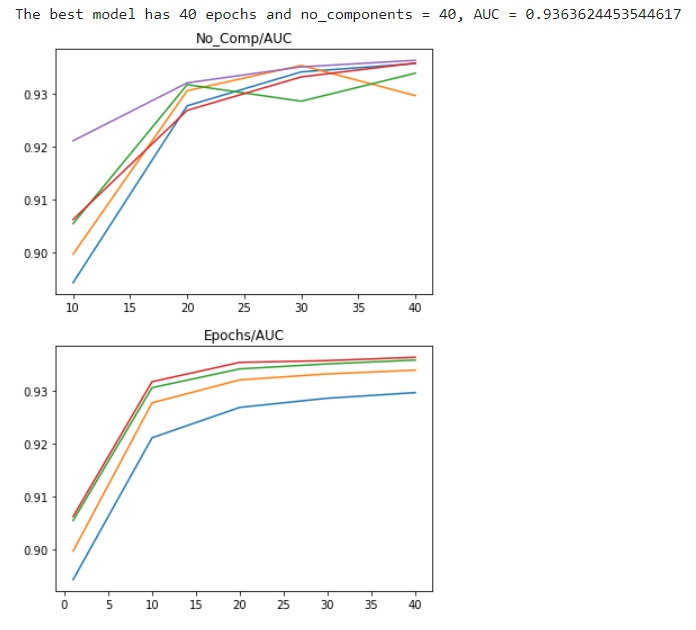

Исходя из полученных графиков и подсчетов получаем оптимальные параметры:
*   Количество эпох - 30 (поскольку разница между 30 и 40 меньше 0.001),
*   Число компонент - 40.





In [ ]:
model = LightFM(loss='warp', no_components = best_params[1])
model.fit(interactionsTrain,
      item_features= item_features,
      sample_weight= weightsTrain,
      epochs=best_params[0],
      num_threads = 4)

In [ ]:
score = auc_score( 
        model, train_interactions= interactionsTrain, 
        test_interactions= interactionsTest, 
        item_features=item_features, 
        num_threads=4).mean()
print(score)

0.93354815

In [ ]:
user_id_map, user_feature_map, item_id_map, item_feature_map= datasetTrain.mapping()

In [ ]:
class recommendation_sampling:
    
    def __init__(self, model, items, user_to_product_interaction_matrix, 
                user2index_map, item_features, df_titles):
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
        self.item_features = item_features
        self.df_titles = df_titles
    
    def recommendation_for_user(self, user):
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        users = userindex
        
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        scores = self.model.predict(users, np.arange(self.user_to_product_interaction_matrix.shape[1]),item_features = item_features)
        
        top_items = self.items[np.argsort(-scores)]
        ind = np.argsort(-scores)
        
        # print("User %s" % user)
        # print("     Known positives:")
        
        # for x in known_positives[:3]:
        #     a = df_ratings[df_ratings['userId']==user]
        #     print("                - %s" % df_titles['title'][x-1])
        #     print("                  Score: %s" % a[a['movieId']==x].values[0][2])
            
        print("     Recommended:")
        i=0
        for x in top_items[:10]:
            print("                - %s" % df_titles['title'][x-1])
            # print("                  Score: %s" %scores[ind[i]])
            i=i+1

In [ ]:
recom = recommendation_sampling(model = model, items = df_movie_features.movieId, user_to_product_interaction_matrix = interactionsTrain, user2index_map = user_id_map, item_features = item_features, df_titles = df_titles)
recom.recommendation_for_user(5431)

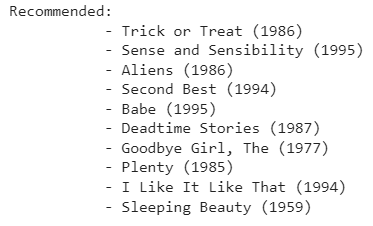

# **Итоги**

Как мы видим обе модели справляются неплохо, не смотря на то, что они выдали разные рекомендации пользователю. Но сравнить их математически для выбранных метрик оказалось не так-то просто, поскольку, к сожалению, не очень получилось реализовать оценку ROC-AUC для ALS в силу большого количества затрачиваемого для этого вычисления времени. Однако, стоит отметить, что у LightFM есть большое преимущество по скорости работы. Поэтому я бы выбрала эту модель как лучшую.
